1. 
First need to read in the weekly returns for the 9 specified stocks from the period Jan 2005 - Dec 2009.
Stocks are Wells Fargo, JP Morgan, Apple, Microsoft, Google, IBM, Walmart, AIG, and GE.

In [101]:
#Need to run this command at anaconda prompt: "$ pip3 install yfinance"
import arch
from matplotlib import pyplot as plt
import math
import numpy as np
import pandas as pd
import statsmodels.api as sm
import yfinance as yf


In [103]:
#spx is the sp500
data = yf.download(
        tickers = 'wfc jpm aapl msft googl ibm wmt aig ge spy', 
        start = "2005-01-01", 
        end = "2008-12-31",
        interval = "1wk",
        group_by = 'ticker',
        threads = True)

[*********************100%***********************]  10 of 10 completed


Now lets turn this multi-index df into a regular df and looking only at AdjClose which we'll use to calculate 
the logreturn values weekly. Also, periodic NA values result from yfinance throwing in random non week ending datapoints, probably resulting from choosing Jan 1st 2005 as the starting point which was a Saturday. So, lets drop those and then calculate log returns. $$ \textbf{Beware, running this cell twice kills the structure, so if you do, you need to run the yf.download cell again before moving on.} $$

In [104]:
AdjClose = data.iloc[:, data.columns.get_level_values(1) == 'Adj Close']
processed = AdjClose.dropna()
processed.columns = processed.columns.droplevel(1)  #turns columns from multi-index to normal index
logRet = np.log(processed)
logRet = logRet.diff()
logRet = logRet.dropna()
logRet.head(25)

,MSFT,AAPL,JPM,SPY,WFC,IBM,WMT,GE,GOOGL,AIG
Date,,,,,,,,,,
2005-01-08,-0.020838,0.013625,-0.006761,-0.001690,-0.024094,-0.017696,0.000000,-0.013423,0.031083,-0.021538
2005-01-15,-0.018158,0.004123,-0.025718,-0.012425,-0.009436,-0.018448,-0.018319,-0.011041,-0.060237,-0.000302
2005-01-22,0.020452,0.048323,0.004062,0.005550,0.006632,0.005506,-0.011001,0.017495,0.010882,-0.003940
2005-01-29,0.005333,0.063626,0.018477,0.023564,0.007572,0.017289,0.019455,0.013889,0.071071,0.024893
2005-02-05,-0.013387,0.029618,-0.005587,0.004481,-0.003416,-0.012886,-0.025769,-0.000552,-0.086638,0.079678
2005-02-12,-0.019048,0.066684,-0.026222,-0.003152,-0.008159,0.001584,0.011830,-0.009707,0.054769,-0.059011
2005-02-19,-0.005987,0.024802,0.012521,0.008602,0.001504,-0.005051,-0.023607,-0.007273,-0.062967,-0.008450
2005-02-26,-0.003173,-0.038605,0.014500,0.010649,0.009966,-0.004644,0.030789,0.020197,0.000161,-0.048717
2005-03-05,-0.003183,-0.061165,-0.038037,-0.019250,-0.011637,-0.009354,-0.028655,-0.008341,-0.044550,-0.004129


2. 
Conduct the NPEB analysis on the individual returns in order to generate the return distribution as well as the covariance relationships.



and via the text, we know that $\mu_{n}$ and $\textbf{V}_{n}$ are 

$$ \mu_{n} = (\hat{\beta}_{1}^{T} x_{1,n-1}, ... , \hat{\beta}_{m}^{T} x_{m,n-1} )^{T} $$

$$ \textbf{V}_{n} = \textbf{\mu}_{n} \textbf{\mu}_{n}^{T} + (\hat{s}_{i,n} \hat{s}_{j,n} \hat{\sigma}_{i,j}) $$

Then, search for $\eta$ by minimizing (2.11) for given $\lambda$, followed by searching for $\lambda$ over a grid to minimize (maximize right?) the information ratio: 
$$E_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b}) / \sqrt{(Var_{\mu, \Sigma} (w_{\lambda}^{T} r - r_{b})} $$

In [127]:
#Lets first find the prior distribution via MLE estimators (practice of NPEB). 
#First, we can model the return at time t as Linear Regression with Garch errors


X = logRet.shift(1) #we'll be using prevoius observations
risk_lambda = [2**i for i in range(-3,7)]
numAssets = 9
onePerReturn = []
windowSize = 120
rescale = 1

s_prev = np.zeros((len(logRet), numAssets))


for time, i in enumerate(range(100, 101)): #len(logRet))):
    mu_n = np.zeros(numAssets)
    V_n = np.ones((numAssets, numAssets))
    z_t = np.ones(numAssets)
    
    iterator = 0

    for col in logRet.columns:
        if col == 'SPY':
            continue
        leftIndex = max(0, i - windowSize)
        col_1 = X.columns.get_loc('SPY')
        col_2 = X.columns.get_loc(col)
        exog = X.iloc[1:i, [col_1, col_2]]
        y = logRet.iloc[1:i, logRet.columns == col].to_numpy().flatten()
        
        
        #Rescale y? How does that change parameter values
        y = y * rescale

        model = arch.arch_model(y, x = exog, mean = 'ARX', dist = 't')
        res = model.fit()
        
        data = np.array([1,X.iloc[i, col_1], X.iloc[i, col_2]])
        #Calculate mu_n, partially V_n for optimal Weight Portfolio
        #assume that the parameter list has the 'ARX' model parameters first
        
        
        #parmams list as follows: also need to undo rescale for parameters
        Beta_constant = res.params[0] / rescale
        Beta_SPY = res.params[1] / rescale
        Beta_prevReturn = res.params[2] / rescale
        s_omega = res.params[3]
        s_alpha = res.params[4]  
        s_beta = res.params[5] / rescale
        s_nu = res.params[6]

        
        mu_n[iterator] = np.transpose(np.array([Beta_constant, Beta_SPY, Beta_prevReturn]))@data 
        
        s_i = np.sqrt(s_omega + s_alpha*(s_prev[time-1,iterator]**2) + \
                      s_beta*(logRet.iloc[time-1, logRet.columns == col]**2))
        
        s_prev[time, iterator] = s_i
        
        for i in range(0, numAssets):
            V_n[iterator, i] *= s_i

        #To get cov(zi, zj), need to divide epsilon by s
        epsilon = logRet.iloc[i, logRet.columns == col] - mu_n[iterator]
        z_t[iterator] = epsilon / s_i
        
        iterator += 1
        
    #Finish calculating V_n, mult by sigma's

    for i in range(0, numAssets):
        for j in range(0, numAssets):
            V_n[i,j] *= (z_t[i]*z_t[j])
        
    #Finish calulating V_n, outer product of mu_n
    for idx1, i in enumerate(mu_n):
        for idx2, j in enumerate(mu_n):
            V_n[idx1, idx2] += i*j
            
            
    print(V_n)

    optimalWeights = calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet)
    #onePerReturn[logRet[i].index] = np.transpose(optimalWeights)@logRet.iloc[i, logRet.columns != 'SPY']
        
    

/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0006677. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001053. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/quinnhollister/opt/anaconda3/

Iteration:      1,   Func. Count:      9,   Neg. LLF: 567.6149268325057
Iteration:      2,   Func. Count:     23,   Neg. LLF: 182.9235321648329
Iteration:      3,   Func. Count:     33,   Neg. LLF: 17.840185402006664
Iteration:      4,   Func. Count:     43,   Neg. LLF: 2724.867620681298
Iteration:      5,   Func. Count:     54,   Neg. LLF: -218.06889336015885
Iteration:      6,   Func. Count:     63,   Neg. LLF: -226.35513049718983
Iteration:      7,   Func. Count:     72,   Neg. LLF: -152.9001745131633
Iteration:      8,   Func. Count:     82,   Neg. LLF: -141.08416064561163
Iteration:      9,   Func. Count:     91,   Neg. LLF: -151.9805199121979
Iteration:     10,   Func. Count:    100,   Neg. LLF: -213.4501079007803
Iteration:     11,   Func. Count:    109,   Neg. LLF: -147.56950507266566
Iteration:     12,   Func. Count:    118,   Neg. LLF: -228.24100956772378
Iteration:     13,   Func. Count:    126,   Neg. LLF: -227.83963896078328
Iteration:     14,   Func. Count:    135,   Neg.

/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 9.807e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 8.63e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/Users/quinnhollister/opt/anaconda3

Iteration:      2,   Func. Count:     24,   Neg. LLF: 269.3040433634248
Iteration:      3,   Func. Count:     37,   Neg. LLF: -4.314865546147936
Iteration:      4,   Func. Count:     48,   Neg. LLF: -12.357884369564896
Iteration:      5,   Func. Count:     58,   Neg. LLF: 21.685949511362384
Iteration:      6,   Func. Count:     69,   Neg. LLF: -27.50737177508172
Iteration:      7,   Func. Count:     78,   Neg. LLF: -27.80003212744398
Iteration:      8,   Func. Count:     87,   Neg. LLF: -28.124426052739054
Iteration:      9,   Func. Count:     95,   Neg. LLF: -28.095735659671856
Iteration:     10,   Func. Count:    104,   Neg. LLF: -28.12866934802534
Iteration:     11,   Func. Count:    113,   Neg. LLF: -28.12984853079487
Iteration:     12,   Func. Count:    121,   Neg. LLF: -28.130026891465754
Iteration:     13,   Func. Count:    129,   Neg. LLF: 162.96467599392076
Iteration:     14,   Func. Count:    142,   Neg. LLF: -14.939717245123482
Iteration:     15,   Func. Count:    154,   Neg

Iteration:     11,   Func. Count:     99,   Neg. LLF: -1.732819694549363
Iteration:     12,   Func. Count:    108,   Neg. LLF: -0.694880757537109
Iteration:     13,   Func. Count:    117,   Neg. LLF: -11.560331993714051
Iteration:     14,   Func. Count:    126,   Neg. LLF: -10.045486850474491
Iteration:     15,   Func. Count:    135,   Neg. LLF: -13.500070235576949
Iteration:     16,   Func. Count:    144,   Neg. LLF: -4.285167904589746
Iteration:     17,   Func. Count:    154,   Neg. LLF: -6.402257894234117
Iteration:     18,   Func. Count:    164,   Neg. LLF: 115.84493918792994
Iteration:     19,   Func. Count:    178,   Neg. LLF: 6.024256803846745
Iteration:     20,   Func. Count:    190,   Neg. LLF: 94.22944201782923
Iteration:     21,   Func. Count:    199,   Neg. LLF: -9.979179919734701
Iteration:     22,   Func. Count:    208,   Neg. LLF: -11.473246176272044
Iteration:     23,   Func. Count:    217,   Neg. LLF: -11.426019139199678
Iteration:     24,   Func. Count:    226,   Neg.

/Users/quinnhollister/opt/anaconda3/lib/python3.8/site-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.001211. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [ ]:
#Define function for calculating mu and V


In [123]:
#Define function for calculating optimal weight portfolio and eta for given lambda
def calcOptPortfolioWeight(mu_n, V_n, risk_lambda, i, logRet):
    informationRatio = -1000000 #essentially like -inf
    optWeight = np.ones(mu_n.shape)
    
    
    for lam in risk_lambda:
        inverseV_n = np.linalg.inv(V_n)
        ones = np.ones(mu_n.shape[0])
    
        A_n = np.transpose(mu_n)@inverseV_n@ones
        B_n = np.transpose(mu_n)@inverseV_n@mu_n
        C_n = np.transpose(ones)@inverseV_n@ones
        
        print(inverseV_n)
    
        #assert (B_n - (A_n**2)/C_n)*(B_n - ((A_n**2)/C_n) - 1) < 0
        #print("C(eta) has no minimum")
    
        Z2 = (B_n - ((A_n**2)/C_n))*(B_n - ((A_n**2)/C_n) - 1)
        Z1 = ((1/(2.0*lam)) + (A_n/C_n))*(B_n - ((A_n**2)/C_n))
        eta = -(Z1*2*lam)/Z2
        
        term1 = (1.0/C_n)*inverseV_n@ones 
        term2 = (eta/(2*lam))*inverseV_n@(mu_n - (A_n/C_n)*ones)
        weight = term1 + term2
        newInfoRatio = infoRatio(weight, i, lam, logRet)
        if newInfoRatio > informationRatio:
            optWeight = weight
        print(weight)
        
    return optWeight
        
def infoRatio(weight, i ,lam, logRet):
    
    #E[w^T * mu]
    #E[w^T * SIGMA * w]
    #Var[w^T * mu]
    
    B = 500
    for i in range(1,B)
        left_index = max(0, i-120)
        mu, V = sampleStat(logRet.iloc[left_index:i,logRet.columns != 'SPY' ].sample(n=numObs, replace=True))
        expected1 += np.transpose(weight)@mu
        expected2 += np.transpose(weight)@V@weight
        expected3 += (expected1)**2
        
    expected1 /= 500
    expected2 /= 500
    Variance = (expected3 / 500) - (expected1**2) 
    
    infoRatio = 
        
        
        
        
def sampleStat(data):
    mu = data.mean(axis = 0)
    V = data.cov()

5. 
Using these dynamic portfolio weights, model the cumulative returns for the period and compare them to plug-in portfolio.

In [12]:
#Lets first find the plug-in returns using the same idea with a sliding window

def optimalWeight(retMean, retCov, targetReturn, riskFree):
    inverseCov = np.linalg.inv(retCov)
    riskAdjMean = np.subtract(retMean, riskFree)
    one = np.ones((len(retMean),1))
    
    A = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@one)
    B = np.ndarray.item(np.transpose(riskAdjMean)@inverseCov@riskAdjMean)
    C = np.transpose(one)@inverseCov@one
    D = B*C - A**2

    numerator = B*inverseCov@one - A*inverseCov@riskAdjMean
    numerator += targetReturn*(C*inverseCov@riskAdjMean - A*inverseCov@one)
    optimalWeights = numerator * (1/D)

    return optimalWeights

In [50]:
windowSize = 120
rf = 0
numAssets = 9 
maxRet = 0.01   #This is very conservative, is there some way to enforce no short-selling?

#In order to find the plug-in portfolio that returns the highest information ratio, we'll need to do some
#grid searching

mu = np.linspace(0.1, maxRet, 51)

plugInReturn = []
riskFree = np.full((numAssets,1), rf)


for i in range(10, len(logRet)):   #algo unstable for low history, so we start at n = 10
    leftIndex = max(0, i - windowSize)
    sampleMean = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].mean(axis = 0)
    sampleCov = logRet.iloc[leftIndex:i, logRet.columns != 'SPY'].cov()
    periodRet = logRet.iloc[i, logRet.columns != 'SPY']
    marketRet = logRet.iloc[i, logRet.columns == 'SPY']
        
    sampleMeanMatrix = sampleMean.to_numpy()
    sampleMeanMatrix = sampleMeanMatrix.reshape((numAssets,1))
    sampleCovMatrix = sampleCov.to_numpy()
    periodRetMatrix = periodRet.to_numpy()
    
    InfoRatio = -10000000  #just need it to be a value that no other value will fail to be a max
    maxWeight = np.ones((numAssets,1))
    
    for j in mu:
        
        optimalweights = optimalWeight(sampleMeanMatrix, sampleCovMatrix, j, riskFree)
        expectedReturn = np.ndarray.item(np.transpose(optimalweights)@sampleMeanMatrix)
        expectedVariance = np.ndarray.item(np.transpose(optimalweights)@sampleCovMatrix@optimalweights)
        temp = (expectedReturn - marketRet.values[0]) / np.sqrt(expectedVariance)
        if temp > InfoRatio:
            maxWeight = optimalweights
            
    iRet = np.transpose(maxWeight)@periodRetMatrix 
    plugInReturn.append(np.ndarray.item(iRet) - marketRet.values[0])



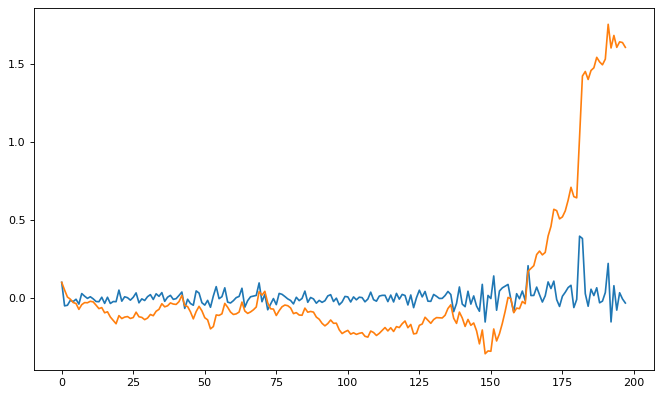

In [51]:
plt.figure(figsize=(10,6), dpi = 80)

cumulative = []
cumsum = 0
for i in plugInReturn:
    cumsum += i
    cumulative.append(cumsum)

plt.plot(plugInReturn)
plt.plot(cumulative)
#plt.plot(logRet['SPY'])


This is obviously so wildly outperforming the index so something is wrong with the code. My guess is that we get a massive jump in perfomance in what seems to be around the 2007 time period, and we have huge short positions in the portfolio that generate massive returns. Need to take a look at what's going wrong for the plug-in portfolio. 